# Import Module

In [31]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

# Plotting modules 
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
#from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Settings

### Variables

In [32]:
variables = ['tas', 'pr', 'psl', 'SW', 'LW']
var_ceres = ['rsdt','rsut', 'rlut']
truncations = [18, 18, 8, 28, 22]
TITLE = 'Multi-variate'
ylabel = '$E_{tot}$'

### Paths

In [33]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/PPE/CNRM-CM6-1_PPE/'
#path_files='/data/home/globc/peatier/PPE/CNRMppe/PPE/ENSEMBLE2/files/'
path_files='/data/home/globc/peatier/PPE/CNRMppe_error_decomposition/files/'
path_figures = '/data/home/globc/peatier/PPE/CNRMppe_error_decomposition/Clustering/figures/'

### Functions

In [34]:
def MLR(X_train, pc_train, x_pred) :
    param_names = np.load(file="/data/home/globc/peatier/PPE/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")    

    y_train = pc_train#[:,EOF_nb-1]
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    y_pred = regr.predict(x_pred)
    
    return y_pred

In [35]:
from sklearn.ensemble import RandomForestRegressor
def RF(X_train, Y_train, x_pred) :

    RF = RandomForestRegressor()
    RF.fit(X_train, Y_train)
    y_pred = RF.predict(x_pred)
    #print(lasso.alpha_)
    #print(lasso.coef_)
    
    return y_pred

In [36]:
from sklearn.neural_network import MLPRegressor

def NN(X_train, Y_train, x_pred) :

    MLP = MLPRegressor(hidden_layer_sizes=(1,40))
    MLP.fit(X_train, Y_train)
    y_pred = MLP.predict(x_pred)
    #print(lasso.alpha_)
    #print(lasso.coef_)
    
    return y_pred

In [37]:
def Lasso(X_train, Y_train, x_pred) :

    alphas=[0.01,0.02,0.03,0.05,0.1,0.2,0.5]
    lasso = linear_model.Lasso(alpha=0.0005)
    lasso.fit(X_train, Y_train)
    y_pred = lasso.predict(x_pred)
    
    return y_pred

In [38]:
def get_3D_tas_xarr(path, filename, variables):
#    “”"
#    This function read the netCDF file of monthly data, compute the radiative budget, perform a yearly mean and 
#    return a dataframe
#    “”"
    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    tas = df['tas']
    #
    return tas

In [39]:
def MSE(mod, obs, W_rmse_2D) :
    diff_tmp = (mod - obs)**2 * W_rmse_2D
    diff = (diff_tmp.sum(['lat', 'lon']))
    return diff

In [40]:
def reconstruct_X(eofs_combined, pc, nb_dims) :
    X_rec_tmp = np.dot(eofs_combined.transpose(),pc)
    if nb_dims == 3 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat", "time"]).transpose('time', 'lat', 'lon')
    if nb_dims == 2 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat"]).transpose('lat', 'lon')
    
    X_rec['lat'] = eofs_combined['lat']
    X_rec['lon'] = eofs_combined['lon']
    return X_rec

In [41]:
def MSE_rec(rec_anom_mod_w, rec_anom_obs_w, Mean, W_rmse_2D) :
    mod = rec_anom_mod_w/W_eof_2D + Mean
    obs = rec_anom_obs_w/W_eof_2D + Mean
    diff = MSE(mod, obs, W_rmse_2D)
    return diff

# Get data

In [42]:
path = path_files+'nc/'
Mean={}

for var in variables :
    filename = 'CNRMppe_decomposition_mean_'+str(var)+'.nc'
    Mean_tmp =  xr.open_dataset(path+filename)
    Mean[str(var)] = Mean_tmp[var]

In [43]:
for var in variables :
    W_eof_2D = np.load(path_files+'npy/W_eof_2D_'+var+'.npy')
    W_eof_3D = np.load(path_files+'npy/W_eof_3D_'+var+'.npy')
    W_rmse_2D = np.load(path_files+'npy/W_rmse_2D_'+var+'.npy')

In [44]:
path_files = '/data/home/globc/peatier/PPE/CNRMppe_error_decomposition/files/'

pc_PPE = {}
pc_obs = {}
pc_pred = {}
pc_p1 = {}
for var in variables :
    ## PPE
    path = path_files+'nc/'
    filename = 'pc_PPE_'+var+'.nc'
    pc_PPE_tmp = xr.open_mfdataset(path+filename,combine='by_coords')
    dims_dict = {'time' : 'members', 'mode' : 'modes'}
    pc_PPE[var] = pc_PPE_tmp.rename_dims(dims_dict)
    
    ## observations
    path = path_files+'nc/'
    filename = 'pc_obs_'+var+'.nc'
    pc_obs[var] = xr.open_mfdataset(path+filename,combine='by_coords')
    
    ## p1 - the first line of pc_PPE
    pc_p1[var] = pc_PPE[var]['pcs'][0,:]
    
    ## predictions
    path = path_files+'nc/'
    filename = 'pc_pred_'+var+'.nc'
    pc_pred_tmp = xr.open_mfdataset(path+filename,combine='by_coords')
    pc_pred[var] = pc_pred_tmp.rename({'__xarray_dataarray_variable__' : 'pcs'})

In [45]:
import pickle
path = path_files+'pkl/'

solver = {}
for var in variables :
    # open a file, where you stored the pickled data
    file = open(path+'solver_'+var+'.pkl', 'rb')

    # dump information to that file
    solver[var] = pickle.load(file)

    # close the file
    file.close()

In [46]:
eofs = {}
variances = {}
for var in variables :
    eofs[var] = solver[var].eofsAsCovariance(pcscaling=1)
    variances[var] = solver[var].varianceFraction() 

In [47]:
# Reference simulation
path = path_PPE+'ENSEMBLE1/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
filename = 'tas_*_CNRM-CM6-1_amip_*.nc'
p1_amip = get_3D_tas_xarr(path, filename, ['tas'])

In [48]:
lat = p1_amip['lat']
lon = p1_amip['lon']
eofs_nb = arange(1,104,1)
#eofs_xr = {}
eofs_combined = {}

for var in variables :
    eofs_xr = xr.DataArray(eofs[var], 
                   coords={'eofs': eofs_nb,'lat': lat,'lon': lon}, 
                   dims=["eofs", "lat", "lon"])#.to_dataset(name=var)
    ## --Combine the modes for reconstruction
    eofs_combined[var] = eofs_xr

In [49]:
df_pc_PPE = {}
index_list = {}
cpt_trunc = 0
for var in variables : 
    df_pc_PPE[var] = pd.DataFrame()
    index_list[var] = []
    trunc = truncations[cpt_trunc]
    for EOF_nb in range(0,trunc,1) :
        ind = 'PC '+str(EOF_nb)
        df_pc_PPE[var][ind] = pc_PPE[var]['pcs'][1:,EOF_nb].values
        index_list[var].append(ind)
    cpt_trunc+=1

# Model evaluation

In [50]:
## Correlation
df_fig_corr = {}
Corr_mean_fig = {}
Corr_std_fig = {}
Corr_std_plus = {}
Corr_std_moins = {}

## OSE
df_fig_ose= {}
OSE_mean_fig = {}
OSE_std_fig = {}
OSE_std_plus = {}
OSE_std_moins = {}

In [307]:
mod_stat = 'MLR'

In [308]:
def Eval_bootstrap(var, trunc, X, y, ind_list, Kfold) :

    y_pred = pd.DataFrame()
    rec_anom_obs_w = reconstruct_X(eofs_combined[var][0:trunc,:,:], pc_obs[var]['pseudo_pcs'][0:trunc], nb_dims=2)
    
    MSE_pred = {}
    MSE_true = {}
    pc_y_pred = {}
    pc_y_test = {}
    
    for cpt_boot in range(0,Kfold,1) :
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    
        for ind in ind_list :
#### ------- TO BE MODIFIED DEPENDING ON MODEL CHOICE ------
            tmp = MLR(X_train, y_train[ind], X_test)
#### ------- --------------- ------------------ ----- ------
            y_pred[ind] = tmp
        
        MSE_pred_list = []
        MSE_true_list = []
        pc_y_pred_list = []
        pc_y_test_list = []
        
        for i in range(0,Kfold+1,1) :
        
            ## Statistical prediction
            pc_y_pred_tmp = y_pred.iloc[i]
            rec_anom_mod_w = reconstruct_X(eofs_combined[var][0:trunc,:,:], pc_y_pred_tmp, nb_dims=2)
            tmp = MSE_rec(rec_anom_mod_w, rec_anom_obs_w, Mean[str(var)], W_rmse_2D)
            MSE_pred_list.append(float(tmp))
            pc_y_pred_list.append(pc_y_pred_tmp)
        
            ## True Etas value
            pc_y_test_tmp = y_test.iloc[i]
            rec_anom_mod_w = reconstruct_X(eofs_combined[var][0:trunc,:,:], pc_y_test_tmp, nb_dims=2)
            tmp = MSE_rec(rec_anom_mod_w, rec_anom_obs_w, Mean[str(var)], W_rmse_2D)
            MSE_true_list.append(float(tmp))
            pc_y_test_list.append(pc_y_test_tmp)
        
        MSE_pred['k = '+str(cpt_boot)] = MSE_pred_list
        MSE_true['k = '+str(cpt_boot)] = MSE_true_list
        pc_y_pred['k = '+str(cpt_boot)] = pc_y_pred_list
        pc_y_test['k = '+str(cpt_boot)] = pc_y_test_list
        
    return MSE_pred, MSE_true, pc_y_pred, pc_y_test
    

In [309]:
MSE_pred = {}
MSE_true = {}
pc_y_pred = {}
pc_y_test = {}

cpt_trunc = 0
for var in variables :
    print(var)
    trunc = truncations[cpt_trunc]
    X = np.load(file="/data/home/globc/peatier/PPE/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = df_pc_PPE[var]
    Kfold = 10
    ind_list = index_list[var]
    MSE_pred[var], MSE_true[var], pc_y_pred[var], pc_y_test[var] = Eval_bootstrap(var, trunc, X, y, ind_list, Kfold)
    cpt_trunc+=1

tas
pr
psl
SW
LW


In [310]:
variables_fig = []

for var in variables :
    variables_fig.append(var)
    corr[var] = []
    ose[var] = []
    for cpt_boot in range(0,Kfold,1) :
        
        MSE_pred_tmp = array(MSE_pred[var]['k = '+str(cpt_boot)])
        MSE_true_tmp = array(MSE_true[var]['k = '+str(cpt_boot)])
    
        ## Correlation
        r = np.corrcoef(MSE_pred_tmp,MSE_true_tmp)
        r = r[0,1].round(2)
        corr[var].append(r)
    
        ## Out of Sample Error (euclidian distance)
        OSE_tmp = (MSE_pred_tmp - MSE_true_tmp)**2
        OSE_tmp = OSE_tmp.sum()
        OSE_tmp = (sqrt(OSE_tmp)/len(MSE_true_tmp)).round(2)
        OSE = (OSE_tmp/MSE_true_tmp.mean())*100
        ose[var].append(OSE)
        

In [311]:
MSE_tot_pred = []
MSE_tot_true = []

for cpt_boot in range(0,Kfold,1) :
    cpt_trunc = 0
    MSE_pred_norm = {}
    MSE_true_norm = {}
    for var in variables :
        trunc = truncations[cpt_trunc]
    
        ## p1 reference 
        pc = pc_obs[var]['pseudo_pcs'][0:trunc]
        rec_anom_obs_w = reconstruct_X(eofs_combined[var][0:trunc,:,:], pc, nb_dims=2)
        pc = pc_p1[var][0:trunc]
        rec_anom_mod_w = reconstruct_X(eofs_combined[var][0:trunc,:,:], pc, nb_dims=2)
        MSE_p1_tmp = MSE_rec(rec_anom_mod_w, rec_anom_obs_w, Mean[str(var)], W_rmse_2D)
        MSE_p1 = float(MSE_p1_tmp)
        
        ## Statistical prediction
        MSE_pred_tmp = MSE_pred[var]['k = '+str(cpt_boot)]
        MSE_pred_norm[var] = array(MSE_pred_tmp)/MSE_p1
    
        ## True Etot
        MSE_true_tmp = MSE_true[var]['k = '+str(cpt_boot)]
        MSE_true_norm[var] = array(MSE_true_tmp)/MSE_p1
        
        cpt_trunc+=1
    
    MSE_sum_pred = []
    MSE_sum_true = []
    
    for v in range(0,len(MSE_pred_norm['tas']), 1) :

        ## Statistical prediction
        MSE_sum_pred_tmp = MSE_pred_norm['tas'][v]+MSE_pred_norm['pr'][v]+MSE_pred_norm['psl'][v]+MSE_pred_norm['SW'][v]+MSE_pred_norm['LW'][v]
        MSE_sum_pred.append(MSE_sum_pred_tmp)
    
        ## True Etot
        MSE_sum_true_tmp = MSE_true_norm['tas'][v]+MSE_true_norm['pr'][v]+MSE_true_norm['psl'][v]+MSE_true_norm['SW'][v]+MSE_true_norm['LW'][v]
        MSE_sum_true.append(MSE_sum_true_tmp)
    
    pred_tot = array(MSE_sum_pred)/len(variables)
    true_tot = array(MSE_sum_true)/len(variables)
    
    MSE_tot_pred.append(pred_tot)
    MSE_tot_true.append(true_tot)
    

In [312]:
var = 'Total'
variables_fig = variables.copy()
variables_fig.append(var)
corr[var] = []
ose[var] = []
for cpt_boot in range(0,Kfold,1) :
    
    ## Correlation
    r = np.corrcoef(MSE_tot_pred[cpt_boot],MSE_tot_true[cpt_boot])
    r = r[0,1].round(2)
    corr[var].append(r)
    
    ## Out of Sample Error (euclidian distance)
    OSE_tmp = (MSE_tot_pred[cpt_boot] - MSE_tot_true[cpt_boot])**2
    OSE_tmp = OSE_tmp.sum()
    OSE_tmp = (sqrt(OSE_tmp)/len(MSE_tot_pred[cpt_boot])).round(2)
    OSE = (OSE_tmp/MSE_tot_true[cpt_boot].mean())*100
    ose[var].append(OSE)

In [313]:
df_fig_corr[mod_stat] = pd.DataFrame()
df_fig_ose[mod_stat] = pd.DataFrame()
for var in variables_fig :
    df_fig_corr[mod_stat][var] = corr[var]
    df_fig_ose[mod_stat][var] = ose[var]

In [314]:
## Correlation 
Corr_mean_fig[mod_stat] = df_fig_corr[mod_stat].mean().transpose()
Corr_std_fig[mod_stat] = df_fig_corr[mod_stat].std().transpose()
Corr_std_plus[mod_stat] = Corr_mean_fig[mod_stat]+Corr_std_fig[mod_stat]
Corr_std_moins[mod_stat] = Corr_mean_fig[mod_stat]-Corr_std_fig[mod_stat]

## OSE 
OSE_mean_fig[mod_stat] = df_fig_ose[mod_stat].mean().transpose()
OSE_std_fig[mod_stat] = df_fig_ose[mod_stat].std().transpose()
OSE_std_plus[mod_stat] = OSE_mean_fig[mod_stat]+OSE_std_fig[mod_stat]
OSE_std_moins[mod_stat] = OSE_mean_fig[mod_stat]-OSE_std_fig[mod_stat]

# Plot

In [315]:
mod_list = ['MLR', 'RF', 'Lasso']

In [322]:
def plot_eval_ose(mod) :

    plt.figure(figsize=(8,6))
    OSE_mean_fig[mod].plot.bar(color='coral', rot=45)

    ax = plt.gca()
    cpt = 0
    for var in variables_fig :
        plt.vlines(cpt, OSE_std_moins[mod][var], OSE_std_plus[mod][var], linestyle = '--', color='black', 
                   linewidth=2.5)
        cpt+=1

    plt.ylabel('Prediction error ($\%$) \n compared to param. error '+r'$p(\theta_i)$', fontsize=20)
    plt.hlines(10, -10, 10, linestyle = '-', color='grey', linewidth=1.0)
    plt.title('Statistical model : '+mod, fontsize=20)
    ax.axvspan(4.5, 5.5, alpha=0.15, color='grey')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=15)

    #plt.ylim(0.30,0.41)
    plt.ylim(0,35)

    filename = 'Test_emulateur_appendix_'+mod+'_ose.png'
    plt.savefig(path_figures+filename, bbox_inches='tight' )

    plt.show()

In [323]:
def plot_eval_corr(mod) :

    plt.figure(figsize=(8,6))
    Corr_mean_fig[mod].plot.bar(color='cornflowerblue', rot=45)

    ax = plt.gca()
    cpt = 0
    for var in variables_fig :
        plt.vlines(cpt, Corr_std_moins[mod][var], Corr_std_plus[mod][var], linestyle = '--', color='black', 
                   linewidth=2.5)
        cpt+=1

    plt.ylabel('Correlation \n emulated and true error '+r'$p(\theta_i)$', fontsize=20)
    plt.hlines(0.5, -10, 10, linestyle = '-', color='grey', linewidth=1.0)
    plt.title('Statistical model : '+mod, fontsize=20)
    ax.axvspan(4.5, 5.5, alpha=0.15, color='grey')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=15)

    plt.ylim(0.0,1.0)
    #plt.xlim(0,40)

    filename = 'Test_emulateur_appendix_'+mod+'_corr.png'
    plt.savefig(path_figures+filename, bbox_inches='tight' )

    plt.show()

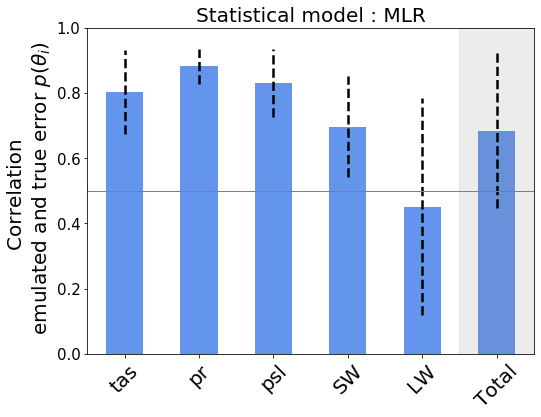

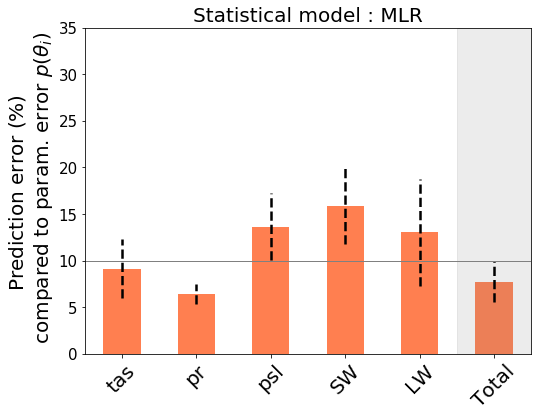

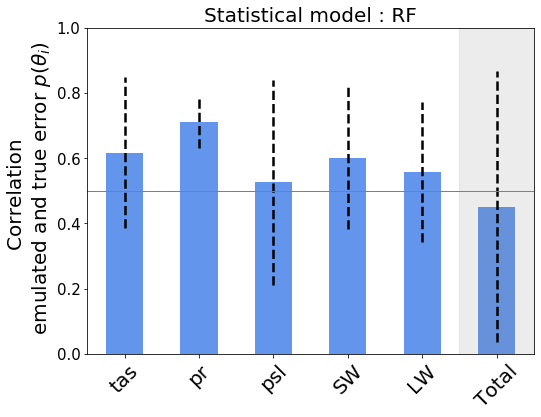

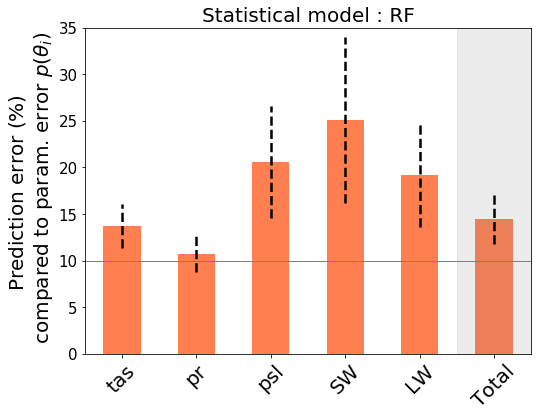

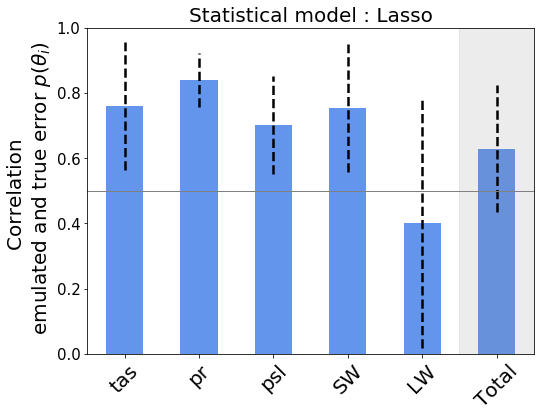

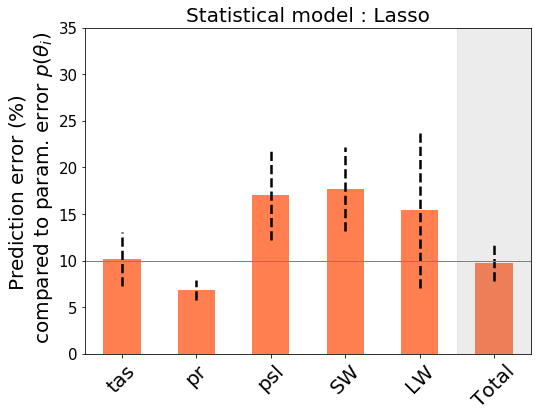

In [324]:
for mod in mod_list :
    plot_eval_corr(mod)
    plot_eval_ose(mod)

In [325]:
path_figures

'/data/home/globc/peatier/PPE/CNRMppe_error_decomposition/Clustering/figures/'